# QuaNNTO Example — Binary Classification with a CV-QONN (moons / circles)

This notebook provides an **end-to-end classification demo** for the `QuaNNTO` library (branch `revisited-code`).

It trains a **2-mode CV-QONN** on a 2D toy dataset (two moons or two circles) using a hybrid training routine, then:
- evaluates test accuracy,
- plots the decision regions,
- and reports a confusion matrix.

---
## Requirements
- Run from the **QuaNNTO repository root** (or install the package in editable mode).
- This notebook uses internal modules:
  - `quannto.core.qnn_trainers`
  - `quannto.core.data_processors`
  - `quannto.core.loss_functions`
  - `quannto.utils.results_utils`

### Notes
- If `datasets/{dataset_name}_inputs.npy` and `datasets/{dataset_name}_outputs.npy` do not exist, this notebook can **generate** them using `scikit-learn` and cache them under `datasets/`.


In [1]:
import sys
from pathlib import Path
# set repo_root to the parent directory to find 'quannto' modules
repo_root = Path.cwd().resolve().parent  
sys.path.insert(0, str(repo_root))

In [2]:
from functools import partial
import numpy as np
import os

from quannto.core.qnn_trainers import *
from quannto.utils.results_utils import *
from quannto.core.data_processors import *
from quannto.core.loss_functions import *

np.random.seed(42)

2026-02-18 18:24:35.653285: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2026-02-18 18:24:35.653313: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2026-02-18 18:24:35.654282: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2026-02-18 18:24:36.328487: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


## 1) Hyperparameters

Model configuration for a **binary classification** task with 2 inputs and 2 outputs.


In [3]:
# === HYPERPARAMETERS DEFINITION ===
qnn_modes = 2
qnn_ladder_modes = [[0]]
qnn_layers = 1
qnn_is_addition = False

include_initial_squeezing = False
include_initial_mixing = False
is_passive_gaussian = False

n_inputs = 2
n_outputs = 2
observable = 'position'

in_norm_range = (-3, 3)   # or None
out_norm_range = (1, 3)   # or None


## 2) Optimizer settings

This example uses the **hybrid** training routine with cross-entropy loss.


In [4]:
# === OPTIMIZER SETTINGS ===
optimize = hybrid_build_and_train_model
loss_function = cross_entropy

# basinhopping_iters=0 typically means: no global basinhopping outer loop (pure hybrid routine).
basinhopping_iters = 0

# Optional initial parameters; None lets the trainer initialize.
params = None


## 3) Dataset loading / generation

We support two standard 2D toy datasets:
- `moons` (nonlinearly separable),
- `circles` (concentric rings).

Datasets are expected at:
- `datasets/{dataset_name}_inputs.npy` with shape `(M, 2)`
- `datasets/{dataset_name}_outputs.npy` with shape `(M, 1)` or `(M,)` (class labels 0/1)

If missing, the notebook generates them and caches to disk.


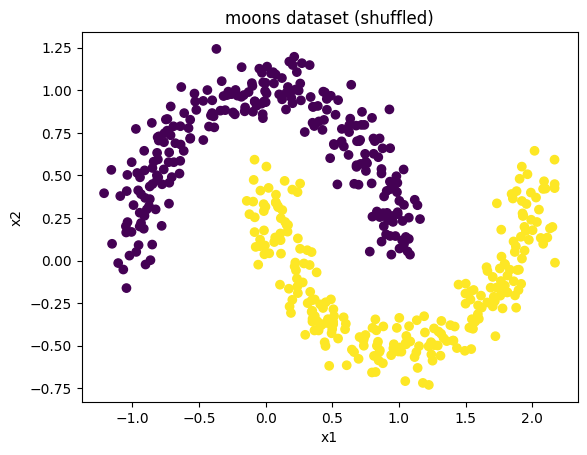

In [5]:
# === DATASET SETTINGS ===
from quannto.utils.path_utils import datasets_dir

dataset_name = 'moons'   # 'moons' or 'circles'
trainset_size = 100
validset_size = 50

num_cats = 2
dataset_size_per_cat = trainset_size // num_cats
validset_size_per_cat = validset_size // num_cats

model_name = (
    f"{dataset_name}_{qnn_modes}modes_{qnn_layers}layers"
    f"_ph{qnn_ladder_modes}_in{in_norm_range}_out{out_norm_range}"
    f"_datasize{trainset_size}"
)

os.makedirs("datasets", exist_ok=True)
dataset_dir = str(datasets_dir() / dataset_name)

inputs_path = f"{dataset_dir}_inputs.npy"
outputs_path = f"{dataset_dir}_outputs.npy"

# 1) FULL DATASET: load if present; otherwise generate and cache
if os.path.isfile(inputs_path) and os.path.isfile(outputs_path):
    with open(inputs_path, "rb") as f:
        inputs = np.load(f)
    with open(outputs_path, "rb") as f:
        outputs = np.load(f)
else:
    raise FileNotFoundError("The requested dataset does not exist, generate it from sklearn.datasets.make_moons or sklearn.datasets.make_circles")

# Ensure consistent shapes
inputs = np.asarray(inputs)
outputs = np.asarray(outputs)
if outputs.ndim == 1:
    outputs = outputs.reshape(-1, 1)

assert inputs.shape[1] == 2, f"Expected 2D inputs, got shape {inputs.shape}"
assert outputs.shape[0] == inputs.shape[0], "Inputs/outputs must have the same number of samples"
assert set(np.unique(outputs.ravel())).issubset({0, 1}), "Binary labels {0,1} expected"

dataset = (inputs, outputs)

# Compute per-feature min/max ranges for per-dimension rescaling
input_ranges = np.array([(np.min(inputs[:, col]), np.max(inputs[:, col])) for col in range(inputs.shape[1])])

# Shuffle once for reproducibility
shuffling = np.random.permutation(len(inputs))
shuffled_dataset = (dataset[0][shuffling], dataset[1][shuffling])

# Optional quick visualization (uses default Matplotlib settings; no custom colors)
import matplotlib.pyplot as plt
plt.figure()
plt.scatter(shuffled_dataset[0][:, 0], shuffled_dataset[0][:, 1], c=shuffled_dataset[1].ravel())
plt.title(f"{dataset_name} dataset (shuffled)")
plt.xlabel("x1")
plt.ylabel("x2")
plt.show()


## 4) Balanced train/validation split

We create **class-balanced** training and validation sets by selecting the same number of samples per class.


In [6]:
# 2) BALANCED TRAINING + VALIDATION DATASETS (class-balanced)
labels = shuffled_dataset[1].ravel()

idx0 = np.where(labels == 0)[0]
idx1 = np.where(labels == 1)[0]

# shuffle class-specific indices (still deterministic because of global seed)
np.random.shuffle(idx0)
np.random.shuffle(idx1)

# train indices
train_idx = np.concatenate([idx0[:dataset_size_per_cat], idx1[:dataset_size_per_cat]])

# validation indices (disjoint from train)
valid_idx = np.concatenate([
    idx0[dataset_size_per_cat:dataset_size_per_cat + validset_size_per_cat],
    idx1[dataset_size_per_cat:dataset_size_per_cat + validset_size_per_cat],
])

# 2. TRAIN DATASET
train_dataset = (shuffled_dataset[0][train_idx], shuffled_dataset[1][train_idx])

# 3. VALIDATION DATASET (set to None to disable validation)
valid_dataset = (shuffled_dataset[0][valid_idx], shuffled_dataset[1][valid_idx])

# 4. TEST DATASET: use the entire dataset
test_dataset = dataset
test_outputs_classes = dataset[1].ravel()

print("Train shapes:", train_dataset[0].shape, train_dataset[1].shape)
print("Valid shapes:", valid_dataset[0].shape, valid_dataset[1].shape)
print("Test  shapes:", test_dataset[0].shape, test_dataset[1].shape)


Train shapes: (100, 2) (100, 1)
Valid shapes: (50, 2) (50, 1)
Test  shapes: (500, 2) (500, 1)


## 5) Preprocessors and postprocessors

- **Input preprocessors**: rescale each feature to `in_norm_range` and pad to length `2N`.
- **Output preprocessors**: one-hot encode labels and (optionally) rescale targets to `out_norm_range`.
- **Postprocessors**: left empty here; we manually apply softmax + argmax for evaluation.


In [7]:
# === PREPROCESSORS AND POSTPROCESSORS ===
in_preprocessors = []
if in_norm_range is not None:
    in_preprocessors.append(
        partial(rescale_set_with_ranges, data_ranges=input_ranges, rescale_range=in_norm_range)
    )
in_preprocessors.append(partial(pad_data, length=2 * qnn_modes))

out_preprocessors = []
out_preprocessors.append(partial(one_hot_encoding, num_cats=num_cats))
if out_norm_range is not None:
    out_preprocessors.append(partial(rescale_data, data_range=(0, 1), scale_data_range=out_norm_range))

postprocessors = []
# Examples (optional):
# postprocessors.append(partial(softmax_discretization))
# postprocessors.append(partial(greatest_probability))
# postprocessors.append(partial(np.ravel))


## 6) Build, train, test

We train the model, evaluate cross-entropy on the full dataset, and compute test accuracy.


In [8]:
# === BUILD, TRAIN AND TEST QNN ===
qnn, train_loss, valid_loss = optimize(
    model_name,
    qnn_modes,
    qnn_layers,
    n_inputs,
    n_outputs,
    qnn_ladder_modes,
    qnn_is_addition,
    observable,
    include_initial_squeezing,
    include_initial_mixing,
    is_passive_gaussian,
    train_dataset,
    valid_dataset,
    loss_function,
    basinhopping_iters,
    in_preprocessors,
    out_preprocessors,
    postprocessors,
    init_pars=params,
)

qnn_preds, norms, loss_value = qnn.test_model(test_dataset[0], test_dataset[1], loss_function)

# Convert raw logits/outputs into probabilities and classes
qnn_probs_preds = softmax_discretization(qnn_preds)
qnn_class_preds = np.ravel(greatest_probability(qnn_probs_preds))

qnn_hits = np.equal(qnn_class_preds, test_outputs_classes).sum()
qnn_accuracy = qnn_hits / len(qnn_class_preds)

print(f"Test loss (cross-entropy): {loss_value}")
print(f"Accuracy: {qnn_hits}/{len(qnn_class_preds)} = {qnn_accuracy:.4f}")


Number of tunable parameters: 14
Number of terms for each trace: [1 1 1]

=== Phase 1: Adam/AdamW warmup (JAX) ===
[Adam] Epoch 0/200 | train loss = 13.5278 | val loss = 12.6449
[Adam] Epoch 1/200 | train loss = 13.5278 | val loss = 12.2433
[Adam] Epoch 2/200 | train loss = 13.1111 | val loss = 11.8403
[Adam] Epoch 3/200 | train loss = 12.6939 | val loss = 11.4366
[Adam] Epoch 4/200 | train loss = 12.2765 | val loss = 11.033
[Adam] Epoch 5/200 | train loss = 11.8597 | val loss = 10.6302
[Adam] Epoch 6/200 | train loss = 11.4442 | val loss = 10.2291
[Adam] Epoch 7/200 | train loss = 11.0307 | val loss = 9.8304
[Adam] Epoch 8/200 | train loss = 10.6201 | val loss = 9.43507
[Adam] Epoch 9/200 | train loss = 10.213 | val loss = 9.04404
[Adam] Epoch 10/200 | train loss = 9.81035 | val loss = 8.65824
[Adam] Epoch 11/200 | train loss = 9.41287 | val loss = 8.27866
[Adam] Epoch 12/200 | train loss = 9.02133 | val loss = 7.90627
[Adam] Epoch 13/200 | train loss = 8.63645 | val loss = 7.54204
[A

## 7) Save outputs and plot results

We save loss curves and raw test outputs, then plot:
- decision regions,
- confusion matrix.


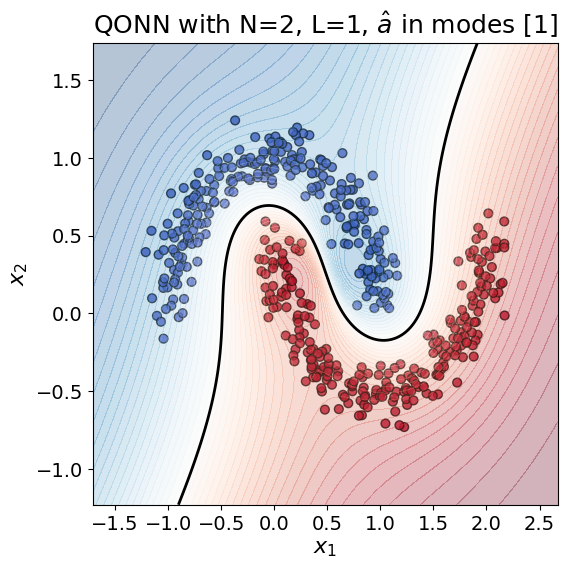

<Figure size 640x480 with 0 Axes>

<Figure size 800x600 with 0 Axes>

In [9]:
# === SAVE AND PLOT QNN MODEL RESULTS ===
os.makedirs("quannto/tasks/models/train_losses", exist_ok=True)
os.makedirs("quannto/tasks/models/valid_losses", exist_ok=True)
os.makedirs("quannto/tasks/models/testing_results", exist_ok=True)

with open(f"quannto/tasks/models/train_losses/{model_name}.npy", "wb") as f:
    np.save(f, np.array(train_loss))
with open(f"quannto/tasks/models/valid_losses/{model_name}.npy", "wb") as f:
    np.save(f, np.array(valid_loss))
with open(f"quannto/tasks/models/testing_results/{model_name}.npy", "wb") as f:
    np.save(f, np.array(qnn_preds))

# Nice labels for plots
nongauss_op = r"$\hat a^\dagger$" if qnn_is_addition else r"$\hat a$"
if qnn.ladder_modes == [[]]:
    plot_title = f"QONN with N={qnn.N}, L={qnn.layers}, None {nongauss_op}"
else:
    plot_title = f"QONN with N={qnn.N}, L={qnn.layers}, {nongauss_op} in modes {np.array(qnn.ladder_modes[0]) + 1}"

# Decision regions + confusion matrix
plot_qnn_decision(test_dataset[0], test_outputs_classes, qnn.evaluate_model, model_name, plot_title)
plot_confusion_matrix(model_name, test_outputs_classes, qnn_class_preds)


## Next steps

- Increase expressivity by raising `qnn_layers` or changing `qnn_ladder_modes`.
- Try photon addition by setting `qnn_is_addition = True`.
- Switch dataset: set `dataset_name = 'circles'`.
- Add postprocessors to integrate softmax/argmax directly into the model evaluation pipeline.
- Tune training by enabling basinhopping (set `basinhopping_iters > 0`) if supported by your hybrid trainer.
